# Филтер со честички

Очекувано време за сработување: 2 дена по 8 часа.

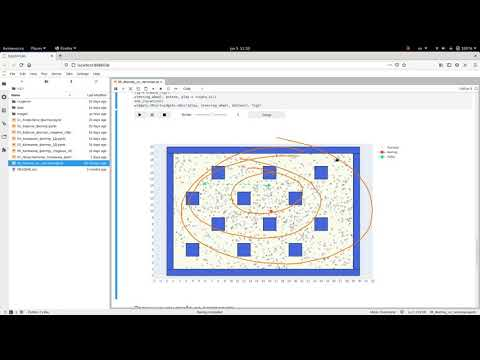

In [21]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('moRVWl40rJs')

## Референци

- [Веројатносна роботика, глава 4](https://e-kursevi.feit.ukim.edu.mk/mod/resource/view.php?id=12791)
- [Филтер со честички - Википедија](https://en.wikipedia.org/wiki/Particle_filter)
- [Филтер со честички - Роџер Лабе](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb)
- [Филтер со честички - Брајан Даглас](https://www.youtube.com/watch?v=NrzmH_yerBU)
- [Мапа на зафатеност - Кирил Стахнис](https://www.youtube.com/watch?v=8ckhPViqneg)
- [Труд за споредба на алгоритмите за избирање](https://users.isy.liu.se/rt/schon/Publications/HolSG2006.pdf)

In [2]:
import numpy as np
import scipy.stats
from plotly import graph_objects as go
import ipywidgets as widgets

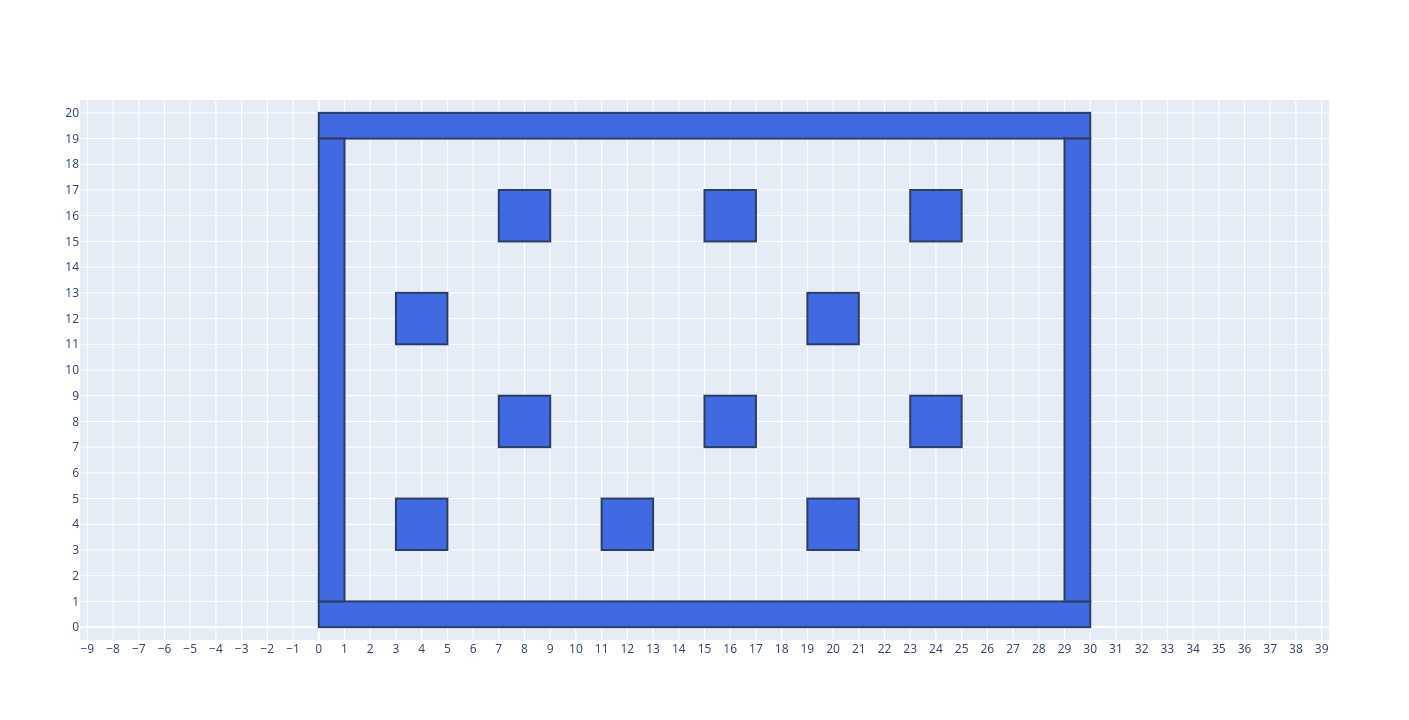

In [24]:
ROWS, COLUMNS = 20, 30

landmarks = np.array([
    [0, COLUMNS, 0, 1],
    [0, COLUMNS, ROWS-1, ROWS],
    [0, 1, 1, ROWS-1],
    [COLUMNS-1, COLUMNS, 1, ROWS-1],
    [3, 5, 3, 5],
    [7, 9, 7, 9],
    [3, 5, 11, 13],
    [11, 13, 3, 5],
    # [11, 13, 11, 13],
    [7, 9, 15, 17],
    [15, 17, 15, 17],
    [15, 17, 7, 9],
    [19, 21, 3, 5],
    [19, 21, 11, 13],
    [23, 25, 15, 17],
    [23, 25, 7, 9],
])

WORLD = np.zeros((ROWS, COLUMNS))
for landmark in landmarks:
    x1, x2, y1, y2 = landmark
    WORLD[y1:y2+1, x1:x2+1] = 1

fig = go.Figure()
for landmark in landmarks:
    x0, x1, y0, y1 = landmark
    fig.add_shape(type='rect', fillcolor='RoyalBlue', x0=x0, x1=x1, y0=y0, y1=y1)
fig.update_xaxes(range=[-0.5, COLUMNS + 0.5], dtick=1)
fig.update_yaxes(range=[-0.5, ROWS + 0.5], dtick=1, scaleanchor='x')
fig.update_layout(height=36*ROWS, width=36*COLUMNS)
fig.show()

In [15]:
class Robot:
    def __init__(self, position, heading):
        self.x, self.y = position
        # self.heading = heading
        self.heading = heading

    
    def move(self, steering_angle, steering_std=0.1, velocity=1, velocity_std=0.1, dt=1):
        self.heading += np.random.normal(steering_angle, steering_std)
        velocity = np.random.normal(velocity, velocity_std)
        self.x += velocity * np.cos(self.heading) * dt
        self.y += velocity * np.sin(self.heading) * dt
        return [self.x, self.y, self.heading]

    def sense(self, Q=0.3, max_sonar_depth=10):
        center = self.one_sense(self.heading,  Q, max_sonar_depth)
        left = self.one_sense(self.heading + np.pi/2,  Q, max_sonar_depth)
        right = self.one_sense(self.heading - np.pi/2,  Q, max_sonar_depth)
        return [left, center, right]
    
    def one_sense(self, heading, Q=0.3, max_sonar_depth=10):
        for d in range(1, max_sonar_depth):
            x = round(self.x + d * np.cos(heading))
            y = round(self.y + d * np.sin(heading))
            if not(0 <= x < COLUMNS and 0 <= y < ROWS) or WORLD[y, x] == 1:
                return d + np.random.normal(scale=Q)
        return max_sonar_depth

In [19]:
class ParticleFilter:
    def __init__(self, N):
        self.particles = self.initialize_particles(N, (0, COLUMNS), (0, ROWS), (0, 2*np.pi))
        self.weights = np.ones(N) / N
        self.N = N
    
    def initialize_particles(self, N, x_range, y_range, heading_range):
        particles = np.empty((N, 3))
        particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=N)
        particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
        particles[:, 2] = np.random.uniform(heading_range[0], heading_range[1], size=N)
        particles[:, 2] %= 2 * np.pi
        return particles
    
    def initialize_particles_random(self, N, x_range, y_range, heading_range):
        particles = np.empty((N, 3))
        particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=N)
        particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
        particles[:, 2] = np.random.uniform(heading_range[0], heading_range[1], size=N)
        particles[:, 2] %= 2 * np.pi
        return particles
    
    def predict(self, steering_angle, steering_std, velocity, velocity_std, dt=1):
        self.particles[:, 2] += np.random.normal(steering_angle, steering_std, size=self.N)
        self.particles[:, 2] %= 2 * np.pi
        velocity = np.random.normal(velocity, velocity_std, size=self.N)
        self.particles[:, 0] += velocity * np.cos(self.particles[:, 2]) * dt
        self.particles[:, 1] += velocity * np.sin(self.particles[:, 2]) * dt
    
    def update(self, z, sensor_noise):        
        distances = np.array([self.sense(particle) for particle in self.particles])
        self.weights *= scipy.stats.norm(distances, sensor_noise).pdf(z).sum(axis=1)
        self.weights += 1e-300  # avoid round-off to zero
        self.weights /= self.weights.sum()

        
    def sense(self, partical, max_sonar_depth=10):
        center = self.one_sense(partical, partical[2], max_sonar_depth=10)
        left = self.one_sense(partical, partical[2] + np.pi/2, max_sonar_depth=10)
        right = self.one_sense(partical, partical[2] - np.pi/2, max_sonar_depth=10)
        return [left, center, right]
        
    def one_sense(self, partical, heading, max_sonar_depth=10):
        for d in range(1, max_sonar_depth):
            x = round(partical[0] + d * np.cos(heading))
            y = round(partical[1] + d * np.sin(heading))
            if not(0 <= x < COLUMNS and 0 <= y < ROWS) or WORLD[y, x] == 1:
                return d
        return max_sonar_depth

    def resample(self):
        indexes = np.random.choice(np.arange(self.N), size=self.N, p=self.weights)
        self.particles = self.particles[indexes]
        self.weights.fill(1 / self.weights.shape[0])

In [6]:
np.finfo(float)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

![Алгоритми за нанови избирање](images/resampling_algorithms.png)

In [17]:
def one_iteration(x=None):
    steering_angle = -steering_wheel.value / 180 * np.pi
    robot_data = robot.move(steering_angle)
    z = robot.sense()
    
    pf.predict(steering_angle=steering_angle, steering_std=0.1, velocity=1, velocity_std=0.05)
    pf.update(z=z, sensor_noise=1)
    pf.resample()
    position_mean = np.average(pf.particles[:, :2], weights=pf.weights, axis=0)

    with fig.batch_update():
        fig.data[0].x, fig.data[0].y = pf.particles[:, 0], pf.particles[:, 1]
        fig.data[1].x, fig.data[1].y = [position_mean[0]], [position_mean[1]]
        fig.data[2].x = [robot_data[0], robot_data[0] + z[0] * np.cos(robot_data[2] + np.pi/2)]
        fig.data[2].y = [robot_data[1], robot_data[1] + z[0] * np.sin(robot_data[2] + np.pi/2)]        
        fig.data[3].x = [robot_data[0], robot_data[0] + z[1] * np.cos(robot_data[2])]
        fig.data[3].y = [robot_data[1], robot_data[1] + z[1] * np.sin(robot_data[2])]        
        fig.data[4].x = [robot_data[0], robot_data[0] + z[2] * np.cos(robot_data[2] - np.pi/2)]
        fig.data[4].y = [robot_data[1], robot_data[1] + z[2] * np.sin(robot_data[2] - np.pi/2)]        
        fig.data[5].x, fig.data[5].y = pf.particles[:, 0], pf.particles[:, 1]

def create_ui():
    button = widgets.Button(description='Чекор')
    button.on_click(one_iteration)
    steering_wheel = widgets.IntSlider(value=0, min=-30, max=30, step=1, description='Волан:')
    play = widgets.Play(value=0, max=300, interval=1000, show_repeat=False)
    play.observe(one_iteration, 'value')
    return steering_wheel, button, play

def create_fig():
    fig = go.FigureWidget()
    for landmark in landmarks:
        x0, x1, y0, y1 = landmark
        fig.add_shape(type='rect', fillcolor='RoyalBlue', x0=x0, x1=x1, y0=y0, y1=y1)
    fig.add_scatter(name='Честици', mode='markers', opacity=0.3, visible='legendonly')
    fig.add_scatter(name='Филтер', mode='markers+lines', marker_size=12, marker_symbol = ['circle', 'x'])
    fig.add_scatter(name='Робот levo', mode='markers+lines', marker_size=12, marker_symbol = ['circle', 'x'], line_dash='dash')
    fig.add_scatter(name='Робот centar', mode='markers+lines', marker_size=12, marker_symbol = ['circle', 'x'], line_dash='dash')
    fig.add_scatter(name='Робот desno ', mode='markers+lines', marker_size=12, marker_symbol = ['circle', 'x'], line_dash='dash')
    xbins, ybins = dict(start=0, end=COLUMNS, size=0.2), dict(start=0, end=ROWS, size=0.2)
    fig.add_histogram2d(name='Хистограм', xbins=xbins, ybins=ybins, colorscale='YlOrBr', showscale=False, opacity=0.7)
    
    fig.update_xaxes(range=[-0.5, COLUMNS + 0.5], dtick=1)
    fig.update_yaxes(range=[-0.5, ROWS + 0.5], dtick=1, scaleanchor='x')
    fig.update_layout(width=36*COLUMNS, height=36*ROWS)
    return fig

In [25]:
robot = Robot(position=(17, 14), heading=1/1*np.pi)
pf = ParticleFilter(N=5000)

fig = create_fig()
steering_wheel, button, play = create_ui()
one_iteration()
widgets.VBox([widgets.HBox([play, steering_wheel, button]), fig])

## Задачи на кои треба да одговорите

1. Проучете го материјалот за филтри со честички во глава 4 од книгата.
1. Поставете почетно верување за позицијата и насоката на роботот.
1. Надоградете го дадениот примерот така што роботот сега ќе има три сензори за далечина (лево, напред и десно) кои се поставени заемно-нормално.
1. Пребарајте на интернет или сами предложете решение како динамички да го менувате бројот на честички, сѐ со цел на почетокот да користиме повеќе честички, а подоцна помалку.
1. Симулирајте робот кој се движи по произволна патека во рамнина.
    - Поставете обележје во околината и дизајнирајте и имплементирајте филтер со честички за да можете да го локализирате роботот.
    - Исцртајте ја неодреденоста за позицијата на работот.
1. Продолжете го претходниот пример така што ќе поставите повеќе обележја и ќе се локализирате по нив.

## Решение

In [9]:
from IPython.lib.display import YouTubeVideo
# YouTubeVideo('ER7nq2fmU-w')

In [10]:
def fix_angle(angle):
    angle %= (2*np.pi)
    if angle > np.pi:
        angle -= 2* np.pi
    return angle

In [11]:
class Robot:   
    def __init__(self, position, heading, landmark):
        self.x, self.y = position
        self.heading = heading
        self.landmark = landmark
        
    def move(self, steering_angle, steering_std=0, velocity=1, velocity_std=0.1, dt=1):
    # def move(self, velocity, velocity_std, heading_std, dt):
        velocity += np.random.normal(0, velocity_std)
        self.heading += np.random.normal(0, steering_angle)
        self.x += velocity * dt * np.cos(self.heading)
        self.y += velocity * dt * np.sin(self.heading)
        return self.x, self.y, self.heading
    
    def sense(self, range_std=0.3, angle_std=np.radians(0.5)):
        distance = (self.landmark[0] - self.x, self.landmark[1] - self.y)
        angle = np.arctan2(distance[1], distance[0]) + np.random.normal(0, angle_std)
        angle = fix_angle(angle)
        distance = np.linalg.norm(distance) + np.random.normal(0, range_std)
        return distance, fix_angle(angle - self.heading)
    
    def simulate(self, dt, velocity, velocity_std, heading_std, range_std, angle_std, sim_steps):
        position_h, measurement_h = [], []
        for _ in range(sim_steps):
            x, y, heading = self.move(velocity, velocity_std, heading_std, dt)
            distance, angle = self.sense(range_std, angle_std)
            position_h.append([x, y, heading])
            measurement_h.append([distance, angle])
        return np.array(position_h), np.array(measurement_h)

In [12]:
class ParticleFilter:
    def __init__(self, N, landmark):
        self.particles = self.initialize_particles(N, (-3, 3), (-3, 3), (0, 2*np.pi))
        self.weights = np.ones(N) / N
        self.N = N
        self.landmark = landmark
    
    def initialize_particles(self, N, x_range, y_range, heading_range):
        particles = np.empty((N, 3))
        particles[:, 0] = np.random.uniform(x_range[0], x_range[1]/2, size=N)
        particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
        particles[:, 2] = np.random.uniform(heading_range[0], heading_range[1], size=N)
        particles[:, 2] %= 2 * np.pi
        particles[:, 2][particles[:, 2] > np.pi] -= 2*np.pi
        return particles
    
    def initialize_particles_random(self, N, x_range, y_range, heading_range):
        particles = np.empty((N, 3))
        particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=N)
        particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
        particles[:, 2] = np.random.uniform(heading_range[0], heading_range[1], size=N)
        particles[:, 2] %= 2 * np.pi
        return particles
    
    def predict(self, steering_angle, steering_std, velocity, velocity_std, dt=1):
        self.particles[:, 2] += np.random.normal(steering_angle, steering_std, size=self.N)
        self.particles[:, 2] %= 2 * np.pi        
        self.particles[:, 2][self.particles[:, 2] > np.pi] -= 2*np.pi
        velocity = np.random.normal(velocity, velocity_std, size=self.N)
        self.particles[:, 0] += velocity * np.cos(self.particles[:, 2]) * dt
        self.particles[:, 1] += velocity * np.sin(self.particles[:, 2]) * dt
    
    def update(self, z, range_std, angle_std):        
        distances_and_angles = np.array([self.sense(particle, range_std, angle_std) for particle in self.particles])
        self.weights *= scipy.stats.norm(distances_and_angles, [range_std, angle_std]).pdf(z).sum(axis=1)
        self.weights += 1e-300  # avoid round-off to zero
        self.weights /= self.weights.sum()

        
    def sense(self, partical, range_std, angle_std):
        distance = (self.landmark[0] - partical[0], self.landmark[1] - partical[1])
        angle = np.arctan2(distance[1], distance[0])
        distance = np.linalg.norm(distance) + np.random.normal(0, range_std)
        return distance, fix_angle(angle - partical[2])

    def resample(self):
        indexes = np.random.choice(np.arange(self.N), size=self.N, p=self.weights)
        self.particles = self.particles[indexes]
        self.weights.fill(1 / self.weights.shape[0])

In [13]:
def one_iteration(x=None):
    steering_angle = -steering_wheel.value / 180 * np.pi
    robot_data = robot.move(steering_angle)
    z = robot. sense()
    distance, angle = z
    
    pf.predict(steering_angle=steering_angle, steering_std=0.1, velocity=1, velocity_std=0.05)
    pf.update(z=z, range_std=0.3, angle_std=np.radians(0.5))
    pf.resample()
    position_mean = np.average(pf.particles[:, :2], weights=pf.weights, axis=0)

    with fig.batch_update():
        fig.data[0].x, fig.data[0].y = pf.particles[:, 0], pf.particles[:, 1]
        fig.data[1].x, fig.data[1].y = [position_mean[0]], [position_mean[1]]
        fig.data[2].x = [robot_data[0], robot_data[0] + distance * np.cos(robot_data[2] + angle)]
        fig.data[2].y = [robot_data[1], robot_data[1] + distance * np.sin(robot_data[2] + angle)]        
        fig.data[3].x = [robot_data[0], robot_data[0] + 3 * np.cos(robot_data[2])]
        fig.data[3].y = [robot_data[1], robot_data[1] + 3 * np.sin(robot_data[2])]        
        fig.data[4].x, fig.data[4].y = pf.particles[:, 0], pf.particles[:, 1]

def create_ui():
    button = widgets.Button(description='Чекор')
    button.on_click(one_iteration)
    steering_wheel = widgets.IntSlider(value=0, min=-30, max=30, step=1, description='Волан:')
    play = widgets.Play(value=0, max=300, interval=1000, show_repeat=False)
    play.observe(one_iteration, 'value')
    return steering_wheel, button, play

def create_fig():
    fig = go.FigureWidget()
    
    fig.add_scatter(name='Честици', mode='markers', opacity=0.3, visible='legendonly')
    fig.add_scatter(name='Филтер', mode='markers+lines', marker_size=12, marker_symbol = ['circle', 'x'])
    fig.add_scatter(name='merenje', mode='markers+lines', marker_size=12, marker_symbol = ['circle', 'x'], line_dash='dash')
    fig.add_scatter(name='Робот ', mode='markers+lines', marker_size=12, marker_symbol = ['circle', 'x'], line_dash='dash')
    xbins, ybins = dict(start=0, end=COLUMNS, size=0.2), dict(start=0, end=ROWS, size=0.2)
    fig.add_histogram2d(name='Хистограм', xbins=xbins, ybins=ybins, colorscale='YlOrBr', showscale=False, opacity=0.7)
    fig.add_scatter(x=[landmark[0]], y=[landmark[1]], name='obelezje', mode='markers', marker_size=12, marker_symbol='star')

    fig.update_xaxes(range=[-0.5, COLUMNS + 0.5], dtick=1)
    fig.update_yaxes(range=[-0.5, ROWS + 0.5], dtick=1, scaleanchor='x')
    fig.update_layout(width=36*COLUMNS, height=36*ROWS)
    return fig

In [14]:
landmark = (12, 15)
robot = Robot(position=(0, 0), heading=np.pi/6, landmark=landmark)
pf = ParticleFilter(N=5000, landmark=landmark)

fig = create_fig()
steering_wheel, button, play = create_ui()
one_iteration()
widgets.VBox([widgets.HBox([play, steering_wheel, button]), fig])